# Exploratory Analysis
This notebook contains the exploratory analysis that will be developed on to produce models.

### Imports

In [1]:
import datahandler.JHU
import datahandler.WorldBank

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300

In [3]:
# set random seeds
tf.random.set_seed(2644)
np.random.seed(2644)

In [4]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [5]:
'+'.join([pio.renderers.default, "iframe"])

'plotly_mimetype+notebook+iframe'

In [6]:
pio.renderers.default = pio.renderers.default + "+iframe"

## High-level examination

In [7]:
country_level_data = datahandler.JHU.global_case_data()

In [8]:
latest_wb_pop = datahandler.WorldBank.latest_worldbank("SP.POP.TOTL")

First we look at the current top-level global trend.

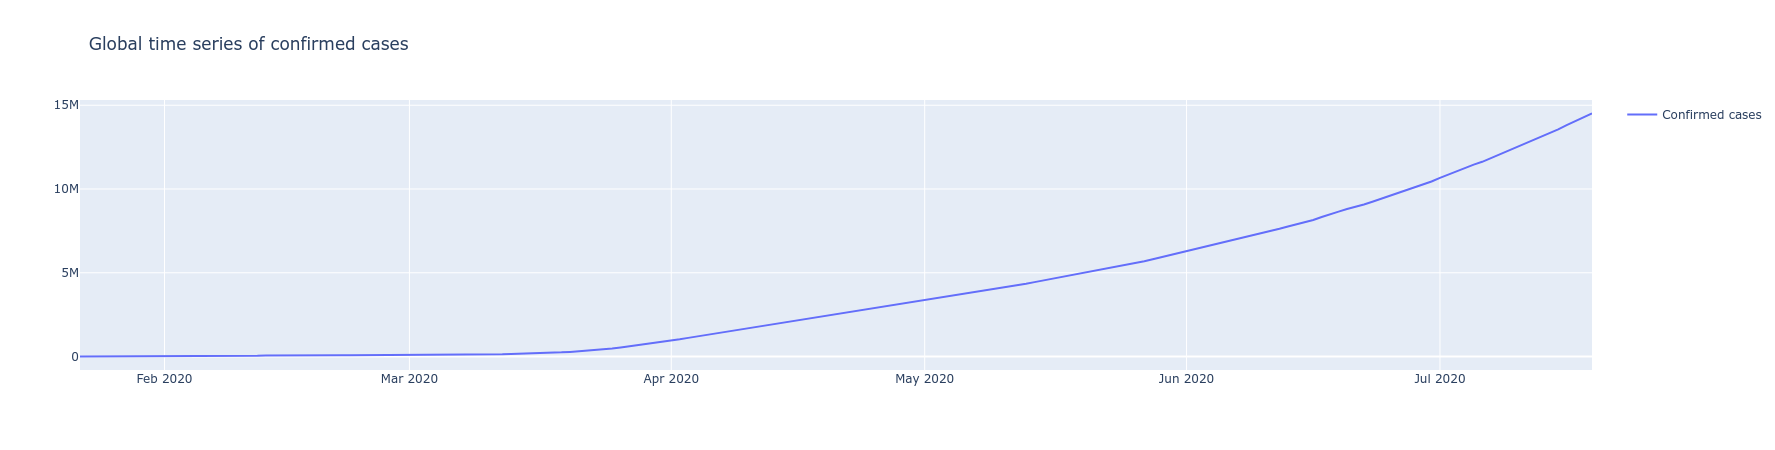

In [9]:
import plotly.graph_objects as go

fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=country_level_data.sum(axis=1),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

Overall, the graph seems to be climbing steadily, possibly exponential at first, then linear? We will therefore plot a log-graph of the cases. An exponential trend should be approximately linear on a log-graph, while a linear trend would appear logarithmic (as all things should be).

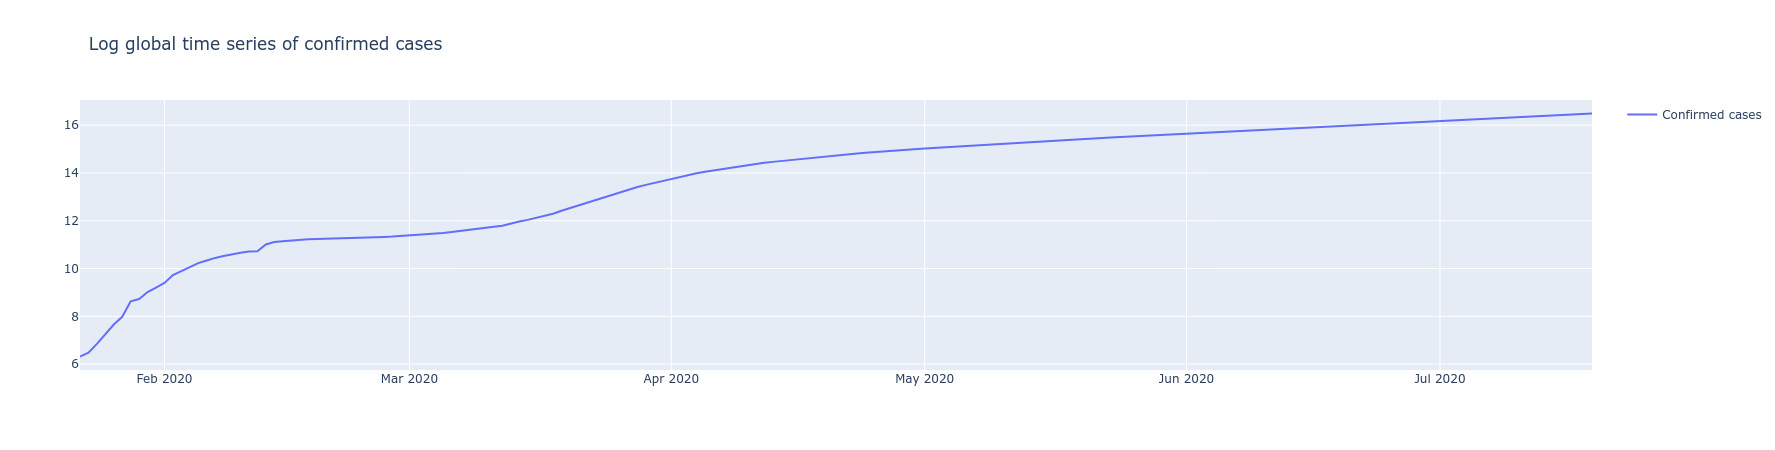

In [10]:
fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=np.log(country_level_data.sum(axis=1)),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Log global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

The logarithmic graph shows a few more interesting insights.

The initial period does appear linear, but it tails off almost linearly before experiencing a jump from 12 February to 13 February. This is of course due to the change in reporting that China adopted on that date. This gives us our first notice that we need to pay attention to such reporting discrepancies, especially since they add additional noise to the data.

The trend then starts to increase again, first linearly before a change in gradient around 12 March, when European countries started to experience their own exponential growth stage. This tails off again to a logarithmic trend after, at around the beginning of April. The trend thereafter is harder to discern visually. 

The overall trend is harder to discern, since it is comprised of different countries with their own infection patterns, with some countries/regions seeing infections rise at different times, e.g. the original spread in China vs the subsequent spread in Europe, and then in the Americas.

## Country-level breakdown
First, we try to align the case numbers meaningfully. 
### Day 0 alignment
In this case, we treat the last day on which there were no cases reported as day 0. 

In [11]:
country_level_data

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-07-15            34994     3752    20770      862     576   
2020-07-16            35070     3851    21355      877     607   
2020-07-17            35229     3906    21948      880     638   
2020-07-18            35301     4008    22549      880     687   
2020-07-19            35475     4090    23084      880     705   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-07-15                       74     111146    33005      10810    19154   
2020-07-16                       74     114783    33559      11233    19270   
2020-07-17                       76     119301    34001      11441    19439   
2020-07-18                       76     122524    34462      11802    19573   
2020-07-19                       76     126755    34877      12069    19655   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-07-15      ...          293469     1009       14581      10428      381   
2020-07-16      ...          294116     1026       15066      10854      381   
2020-07-17      ...          294803     1037       15607      11191      382   
2020-07-18      ...          295632     1044       16186      11483      382   
2020-07-19      ...          296358     1054       16752      11891      383   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-07-15                    7064              10   1526    1895      1089  
2020-07-16                    7412              10   1552    1895      1362  
2020-07-17                    7764              10   1576    2810      1420  
2020-07-18                    8204              10   1581    2980      1478  
2020-07-19                    8549              10   1606    2980      1611  

[180 rows x 188 columns]

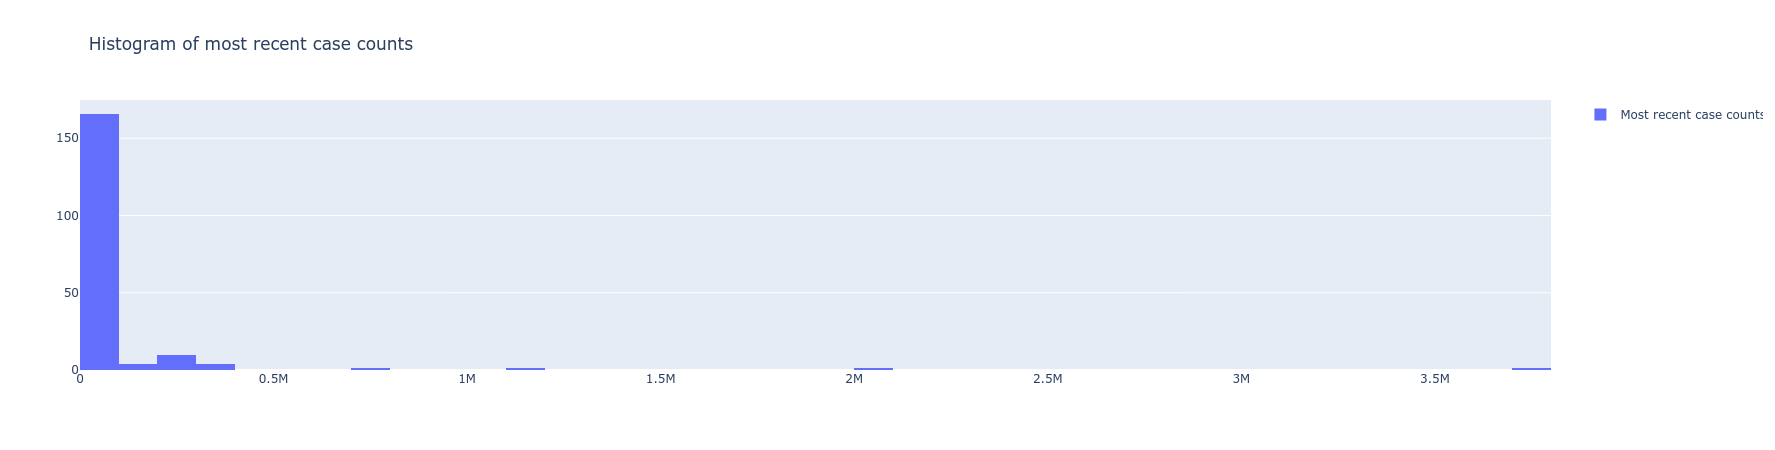

In [12]:
fig = go.Figure(data=[go.Histogram(x=country_level_data.iloc[-1, :],
                                   name='Most recent case counts'
                                  ),
                     ]).update_layout(title='Histogram of most recent case counts',
                                      showlegend=True
                                     )
fig.show()

In [13]:
datahandler.JHU.first_crossed(country_level_data, 1)

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-09
Algeria               2020-03-02
Andorra               2020-03-16
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-05
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-18
Zimbabwe              2020-03-21
Length: 188, dtype: object

In [14]:
datahandler.JHU.align_cases(country_level_data, 1)

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0            1.0      0.0      1.0      1.0     1.0                  1.0   
1            4.0      2.0      3.0      2.0     2.0                  3.0   
2            4.0     10.0      5.0     39.0     2.0                  3.0   
3            5.0     12.0     12.0     39.0     3.0                  3.0   
4            7.0     23.0     12.0     53.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
175          NaN      NaN      NaN      NaN     NaN                  NaN   
176          NaN      NaN      NaN      NaN     NaN                  NaN   
177          NaN      NaN      NaN      NaN     NaN                  NaN   
178          NaN      NaN      NaN      NaN     NaN                  NaN   
179          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          1.0      1.0        0.0      0.0  ...             0.0      0.0   
1          2.0      4.0        4.0      2.0  ...             2.0      4.0   
2          8.0      8.0        5.0      2.0  ...             2.0      6.0   
3         12.0     18.0        5.0      3.0  ...             2.0      8.0   
4         12.0     26.0        6.0      3.0  ...             8.0     29.0   
..         ...      ...        ...      ...  ...             ...      ...   
175        NaN      NaN    11802.0      NaN  ...             NaN      NaN   
176        NaN      NaN    12069.0      NaN  ...             NaN      NaN   
177        NaN      NaN        NaN      NaN  ...             NaN      NaN   
178        NaN      NaN        NaN      NaN  ...             NaN      NaN   
179        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           1.0        0.0      0.0                 0.0             0.0   
1           6.0        2.0      2.0                 4.0             4.0   
2          10.0       10.0      2.0                 7.0             4.0   
3          15.0       17.0      2.0                16.0             4.0   
4          23.0       33.0      2.0                16.0             4.0   
..          ...        ...      ...                 ...             ...   
175         NaN        NaN    381.0                 NaN             NaN   
176         NaN        NaN    381.0                 NaN             NaN   
177         NaN        NaN    382.0                 NaN             NaN   
178         NaN        NaN    382.0                 NaN             NaN   
179         NaN        NaN    383.0                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0      1.0     0.0       1.0  
1      6.0     2.0       3.0  
2      6.0     2.0       3.0  
3      7.0     2.0       3.0  
4     10.0     2.0       3.0  
..     ...     ...       ...  
175    NaN     NaN       NaN  
176    NaN     NaN       NaN  
177    NaN     NaN       NaN  
178    NaN     NaN       NaN  
179    NaN     NaN       NaN  

[180 rows x 188 columns]

As we can observe, the data collection started after some countries had already recorded cases, while other countries did not record any cases for a while into the collection of the dataset. In order to produce a meaningful split, we therefore need to identify the shortest time since the first case was recorded for any country in our dataset.

In [15]:
dates_of_first_cases = datahandler.JHU.first_crossed(country_level_data, 1)
days_with_cases = {x: len(country_level_data[x][dates_of_first_cases[x]-dt.timedelta(1):]) for x in dates_of_first_cases.index}
print(f"Shortest time since first case recorded: {min(days_with_cases, key=days_with_cases.get)} ({days_with_cases[min(days_with_cases, key=days_with_cases.get)]} days)")

Shortest time since first case recorded: Lesotho (60 days)


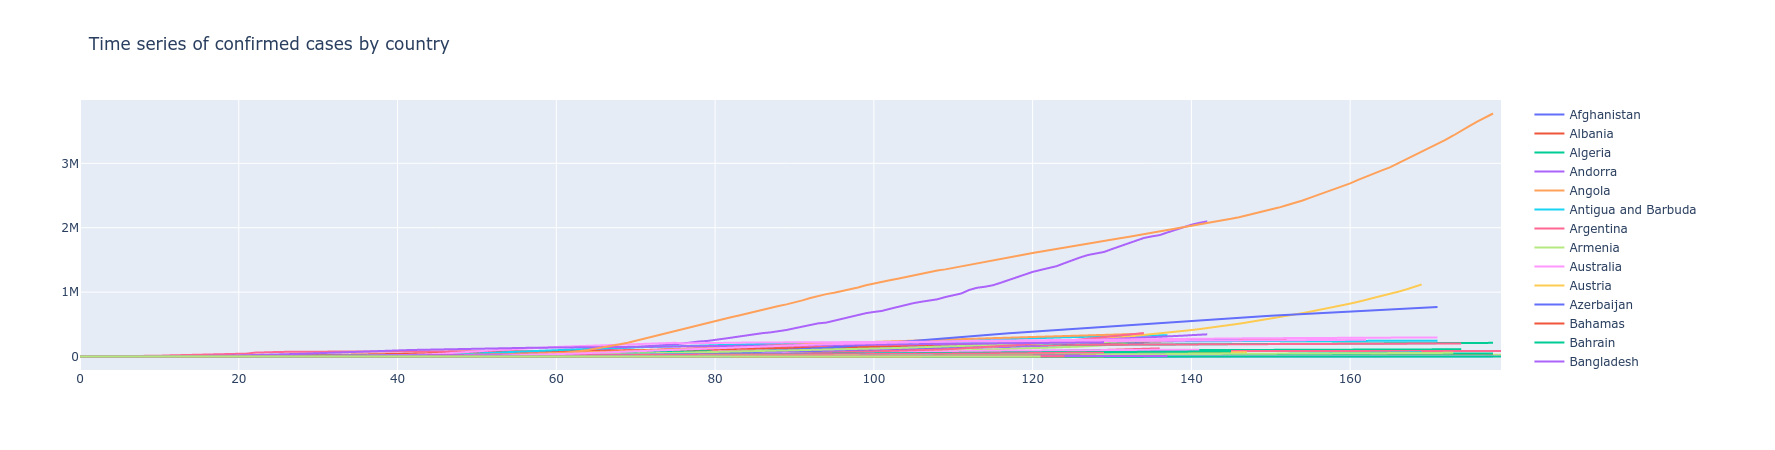

In [16]:
#def generate_scatter_from_column

aligned_1 = datahandler.JHU.align_cases(country_level_data, 1)

fig = go.Figure(data = [go.Scatter(x=aligned_1.index,
                                   y=aligned_1[country].values,
                                   name=country
                                  ) for country in aligned_1.columns]
               ).update_layout(title='Time series of confirmed cases by country',
                               showlegend=True
                              )
fig.show()

The graph appears to show 2 outlier paths, as is rather well known, in the form of the US and Brazil. Apart from that however, most paths are fairly shallow. At this point, fitting a simple linear model regressing on past values would be of interest, as a baseline. While we would expect it to be far out, it can serve as the basis for more sophisticated models.

#### Linear model
This section makes the following assumptions:
* There are no population differences between countries.
    * While this is demonstrably false, a correction requires at the minimum a regression for each country, or additional population information (which will be introduced in later models).
* 2 weeks is sufficient data (the incubation period tends to be around 2 weeks or less). 
* That the dataset starts after some countries have already had cases recorded doesn't matter, since it's mostly the sequences that matter.

This section therefore aims to take the following steps:
1. Create the dataset for the regression.
    * While this is a straightforward model and may not require a validation set, one will be set up anyway so that other models (e.g. cross-validation) can be trained, and used for evaluation on the test set.
    * An arbitrary 60-20-20 split will be used for the train-validation-test split.
        * Because the split involves a time series, the split will have to take place in sequential order (train set before validation, validation set before test), so that the model can retain its usefulness for prediction of future values.
            * The data will be split for each country first, before being added together, to preserve the balance of classes (again, for potential future use).
2. Fit the model on the training set.
3. Test the model on the test set, collecting the MSE.

In [17]:
def train_val_test_split_old(df, seq_length: int):
    '''Splits the input dataframe into train, validation, and test. This function first defines an inner function that operates on a column, returning three dataframes containing the respective sets.
    '''
    def _process_column(df, seq_length: int, col: str):
        print(f"Processing: {col}")
        temp = df[col].dropna()
        n = len(temp) - seq_length + 1
        result = [temp[x:x+seq_length] for x in range(n)]
        test_len = int(n/5)
        train_len = n - (2 * test_len)
        return (result[:train_len], result[train_len:train_len+test_len], result[train_len+test_len:])
    
    train_set = []
    val_set = []
    test_set = []
    
    for col in df.columns:
        train_temp, val_temp, test_temp = _process_column(df, seq_length, col)
        train_set += train_temp
        val_set += val_temp
        test_set += test_temp
        
    train_set = pd.DataFrame([x.reset_index(drop=True) for x in train_set])
    val_set = pd.DataFrame([x.reset_index(drop=True) for x in val_set])
    test_set = pd.DataFrame([x.reset_index(drop=True) for x in test_set])
    return train_set, val_set, test_set

In [18]:
train_df, val_df, test_df = train_val_test_split_old(aligned_1, 15)
train_val_df = train_df.append(val_df)

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

LinearRegression()

In [20]:
train_y_pred = regr.predict(train_df.iloc[:, :-1])
print(f"Training set MSE: {mean_squared_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Training set R^2: {r2_score(train_df.iloc[:, -1], train_y_pred)}")

Training set MSE: 207287.08518654067
Training set R^2: 0.9999426875592993


In [21]:
test_y_pred = regr.predict(test_df.iloc[:, :-1])
print(f"Test set MSE: {mean_squared_error(test_df.iloc[:, -1], test_y_pred)}")
print(f"Test set R^2: {r2_score(test_df.iloc[:, -1], test_y_pred)}")

Test set MSE: 611865.7196231033
Test set R^2: 0.9999928712708771


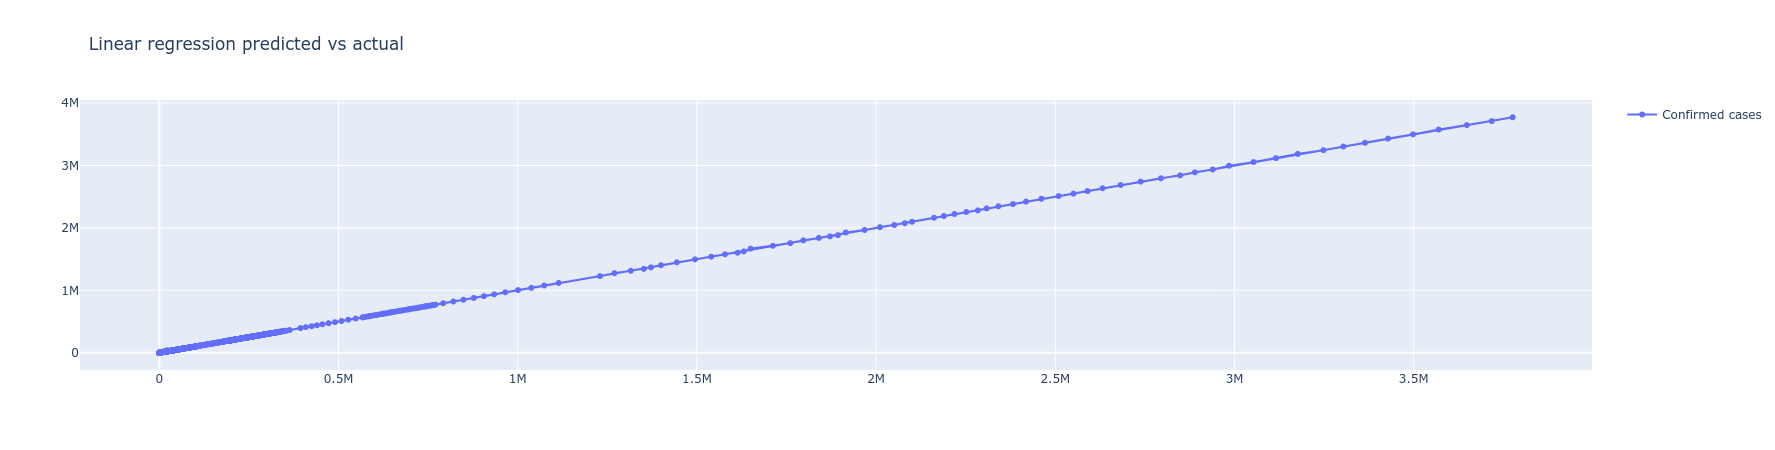

In [22]:
fig = go.Figure(data = go.Scatter(x=test_y_pred,
                                  y=test_df.iloc[:, -1],
                                  mode='lines+markers',
                                  name='Confirmed cases'
                                 )
               ).update_layout(title='Linear regression predicted vs actual',
                               showlegend=True
                              )
fig.show()

Immediately, a problem can be noticed. $R^2$ and MSE do not seem to be very good metrics to use to evaluate the suitability of this regression model. The MSE would be heavily biased by the larger values, as a missed prediction of 1% would be vastly different for predicted values of 1,000 (10), vs 1,000,000 (10,000). In this case, given that the case count is expected to keep increasing, with a range of case counts from the low hundreds to the millions, the MSE could mask the problems with predictions of lower values. If this is the case, we need to find a metric which will measure the value of the error relative to the value of the actual/predicted counts.

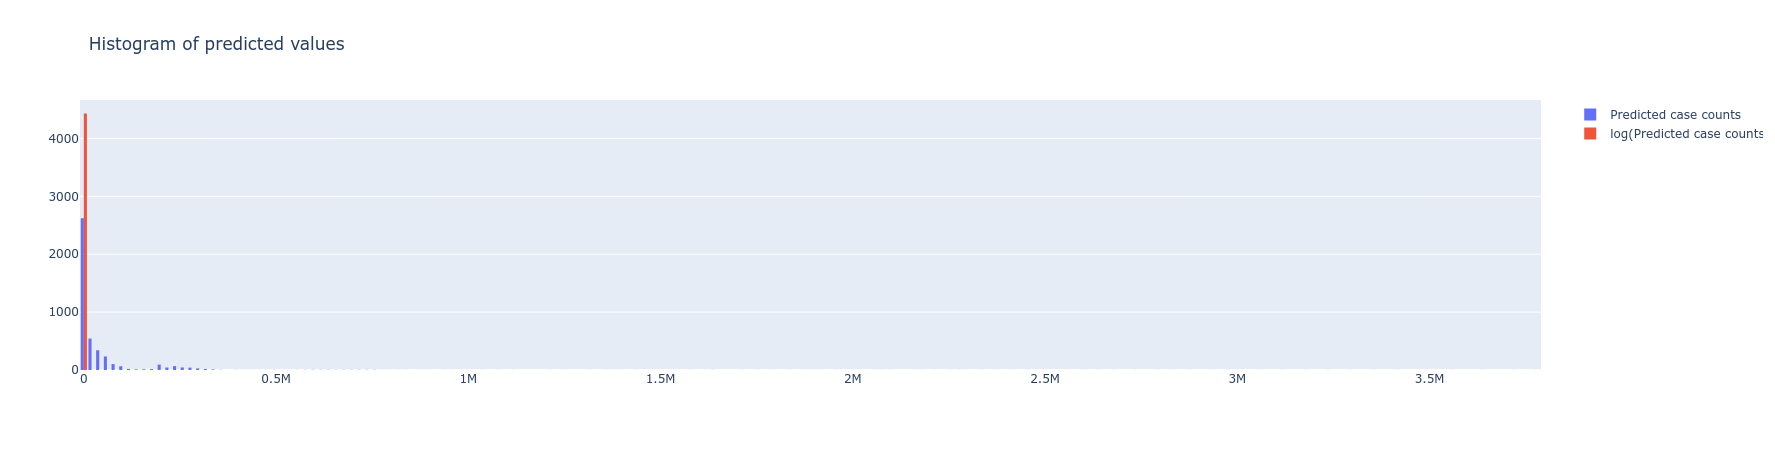

In [23]:
fig = go.Figure(data=[go.Histogram(x=test_y_pred,
                                   name='Predicted case counts'
                                  ),
                      go.Histogram(x=np.log(test_y_pred),
                                  name='log(Predicted case counts)'
                                  )
                     ]).update_layout(title='Histogram of predicted values',
                                      showlegend=True
                                     )
fig.show()

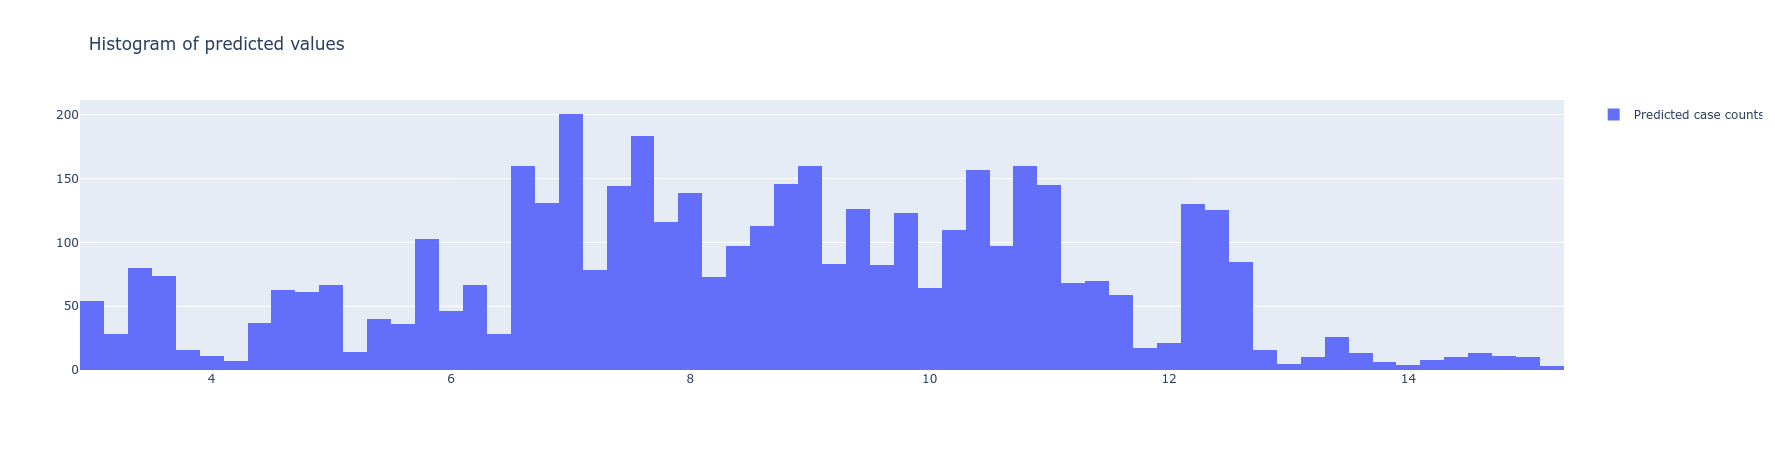

In [24]:
fig = go.Figure(data=[go.Histogram(x=np.log(test_y_pred),
                                   name='Predicted case counts'
                                  )]).update_layout(title='Histogram of predicted values',
                                                    showlegend=True
                                                   )
fig.show()

The histogram suggests that the predicted values are approximately exponentially distributed. This suggests the use of the mean squared log error (MSLE):

$$ \text{MSLE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2. $$

According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), the mean squared log error _"is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc."_ This is indeed the current use-case, where the dependent variable is a population count, and is monitored over time, with exponential growth as seen above.

The use of the MSLE also brings other advantages, such as a higher penalisation of under-prediction as opposed to over-prediction, due to the nature of the logarithmic function. It is also more robust to outliers, since once again, the logarithmic function reduces the effect of an outlier value.

In [25]:
print(f"Training set MSLE: {mean_squared_log_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], test_y_pred)}")

Training set MSLE: 0.07114950889340055
Test set MSLE: 0.016020192227542994


Curiously, the error in the training set seems to be higher than the error in the test set.

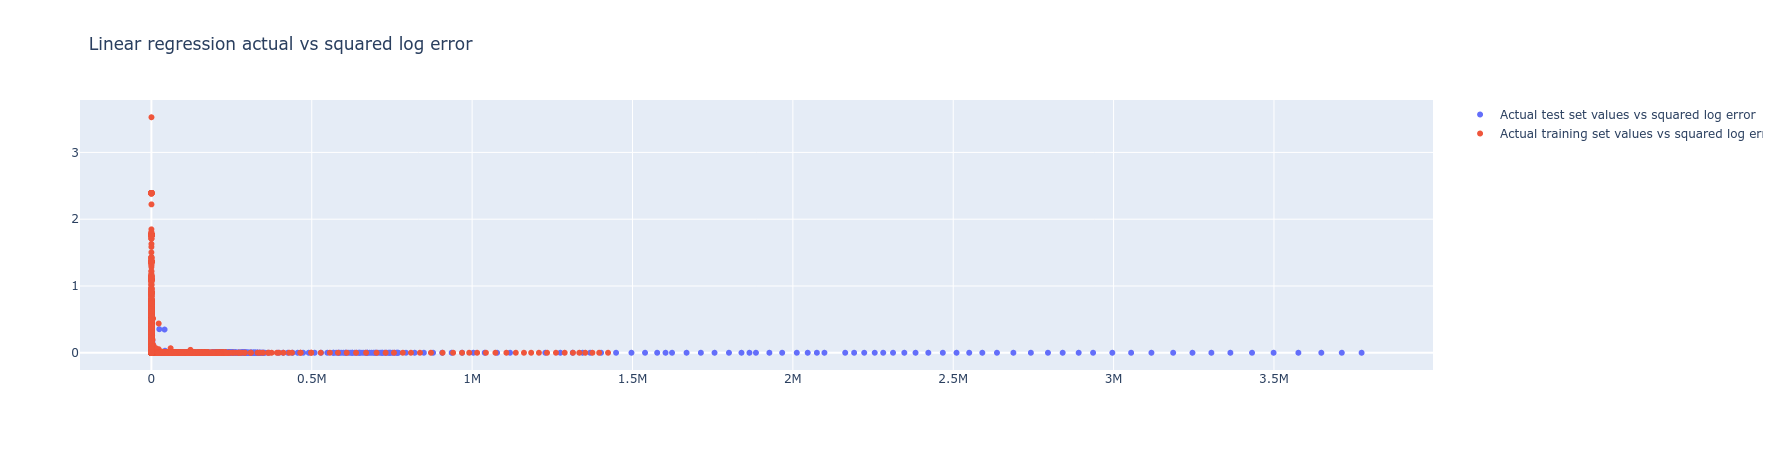

In [26]:
fig = go.Figure(data = [go.Scatter(x=test_df.iloc[:, -1],
                                   y=(np.log(1+test_df.iloc[:, -1]) - np.log(1+test_y_pred))**2,
                                   mode='markers',
                                   name='Actual test set values vs squared log error'
                                  ),
                        go.Scatter(x=train_df.iloc[:, -1],
                                   y=(np.log(1+train_df.iloc[:, -1]) - np.log(1+train_y_pred))**2,
                                   mode='markers',
                                   name='Actual training set values vs squared log error'
                                  )]
               ).update_layout(title='Linear regression actual vs squared log error',
                               showlegend=True
                              )
fig.show()

Plotting the values of the linear regression against the squared log error for both training set and test set (the plot can be manipulated above), it can be observed that the squared log error is highest for lower values. This suggests that the model is not doing well where case counts are much lower values, which would explain the lower test set error, since the training set contains values which are lower, since the training set consists of values preceding the test set values temporally.

This suggests that MSLE cannot be ruled out for comparison between models, which would be training and running on the same data. It also suggests that the simple linear regression model is not a very good model for smaller case counts. This model may however be used as a baseline, which will be doing going forward. As for its relevance with regards to prediction, by now, most countries have seen infections, and few are at levels low enough where the predictions may be a problem. Given the observations above, as time passes, we should in fact expect to see the error levels decrease. For a more directly comparable result however, we will have to train the model on both the training set and the validation set, then predict on the test set in order to obtain its results for a better basis of comparison, as we will be training all models on a concatenation of the training set to the validation set once selected.

A major theoretical issue with using this model however, is that the observations are required to be independent and identically distributed (i.i.d.). However, this is not the case here, as the dataset is cobbled together from past observations of case counts from all countries. This violates the assumption doubly:
* Observations from different countries may not (and are probably not) i.i.d.
    * This point is in fact utilised later by introducing country-specific data, such as population count, urbanisation measures, and lockdown control measures.
* By the nature of the chosen features, we are explicitly searching for a correlation between past values and future values.
    * The next model we explore in fact, will explore this relationship further.

In [27]:
regr_test = linear_model.LinearRegression()
regr_test.fit(train_val_df.iloc[:, :-1], train_val_df.iloc[:, -1])

LinearRegression()

In [28]:
regr_test_y_pred = regr_test.predict(test_df.iloc[:, :-1])
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], regr_test_y_pred)}")

Test set MSLE: 0.018375038044273397


### Auto-correlation
Next, we examine the autocorrelation and partial autocorrelation functions of the data.

In [29]:
autocorr_df = {}
for col in aligned_1.columns:
    print(f"Processing: {col}")
    autocorr_df[col] = [aligned_1[col].diff().autocorr(lag=i) for i in range(aligned_1.dropna(axis=0).shape[0])] # truncate lags to maximum possible length
    
autocorr_df = pd.DataFrame(autocorr_df)#.dropna(axis=0)
autocorr_df

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



Processing: Malaysia
Processing: Maldives
Processing: Mali
Processing: Malta
Processing: Mauritania
Processing: Mauritius
Processing: Mexico
Processing: Moldova
Processing: Monaco
Processing: Mongolia
Processing: Montenegro
Processing: Morocco
Processing: Mozambique
Processing: Namibia
Processing: Nepal
Processing: Netherlands
Processing: New Zealand
Processing: Nicaragua
Processing: Niger
Processing: Nigeria
Processing: North Macedonia
Processing: Norway
Processing: Oman
Processing: Pakistan
Processing: Panama
Processing: Papua New Guinea
Processing: Paraguay
Processing: Peru
Processing: Philippines
Processing: Poland
Processing: Portugal
Processing: Qatar
Processing: Romania
Processing: Russia
Processing: Rwanda
Processing: Saint Kitts and Nevis
Processing: Saint Lucia
Processing: Saint Vincent and the Grenadines
Processing: San Marino
Processing: Sao Tome and Principe
Processing: Saudi Arabia
Processing: Senegal
Processing: Serbia
Processing: Seychelles
Processing: Sierra Leone
Proc

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0      1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1      0.911793  0.905007  0.988061  0.459005  0.360007            -0.019691   
2      0.899705  0.900190  0.979666  0.505633  0.521405            -0.026844   
3      0.899543  0.888205  0.969856  0.516039  0.615299             0.076620   
4      0.889750  0.864906  0.958017  0.412355  0.280924            -0.006175   
5      0.898762  0.871910  0.946562  0.471535  0.561054            -0.025325   
6      0.853697  0.838225  0.933296  0.413019  0.484381            -0.024947   
7      0.834545  0.851190  0.917845  0.448148  0.361094            -0.022682   
8      0.820946  0.841810  0.903430  0.419894  0.545053            -0.021682   
9      0.796796  0.835841  0.884696  0.370968  0.307276            -0.024472   
10     0.786378  0.828019  0.860468  0.431778  0.481442            -0.018663   
11     0.772555  0.822756  0.834457  0.354588  0.347063             0.043762   
12     0.723015  0.805435  0.806813  0.307574  0.329279            -0.012346   
13     0.709217  0.786305  0.775026  0.415524  0.619768            -0.025358   
14     0.667664  0.776415  0.742115  0.239888  0.339353             0.048617   
15     0.648620  0.763221  0.705616  0.307027  0.666664             0.007480   
16     0.612435  0.768728  0.663190  0.320605  0.423305            -0.018660   
17     0.558161  0.749131  0.618401  0.206254  0.403863            -0.024410   
18     0.540550  0.753006  0.567534  0.236446  0.423736            -0.018232   
19     0.508702  0.740614  0.510670  0.227089  0.419872            -0.013342   
20     0.467071  0.710106  0.453682  0.206212  0.420523            -0.021726   
21     0.425931  0.673325  0.402835  0.197590  0.525492            -0.021980   
22     0.387528  0.667428  0.340349  0.143357  0.330614             0.027801   
23     0.360104  0.651350  0.280758  0.141445  0.393210            -0.022833   
24     0.316098  0.620238  0.230383  0.106813  0.426657            -0.020494   
25     0.261743  0.624354  0.200250  0.023783  0.297994             0.071049   
26     0.245201  0.559863  0.179574  0.136143  0.232865            -0.040668   
27     0.175052  0.582837  0.159188  0.002862  0.553596            -0.029709   
28     0.145260  0.559796  0.135807  0.061130  0.417727            -0.013032   
29     0.110517  0.523190  0.127866  0.047492  0.411039            -0.036378   
30     0.069365  0.539518  0.130132 -0.025329  0.657121            -0.034012   
31     0.028688  0.453572  0.138099  0.046210  0.299978            -0.042290   
32    -0.008524  0.418319  0.150835 -0.042557  0.380594            -0.042803   
33    -0.015062  0.368869  0.169916 -0.013491  0.364086            -0.046194   
34    -0.056420  0.322264  0.185180 -0.045304  0.403336            -0.043867   
35    -0.082636  0.286710  0.200228 -0.059685  0.419743            -0.044419   
36    -0.108528  0.168993  0.218778 -0.004882  0.390476            -0.027752   
37    -0.126618  0.132506  0.232465 -0.071256  0.288933            -0.045566   
38    -0.167715  0.060477  0.256715  0.004141  0.253474            -0.046162   
39    -0.197590  0.019882  0.279928 -0.007678  0.246904            -0.029504   
40    -0.216007  0.000024  0.300106 -0.080893  0.141950            -0.043606   
41    -0.229182 -0.014788  0.318114  0.000594  0.152606            -0.047119   
42    -0.253290 -0.038301  0.343678 -0.065469  0.208567            -0.047769   
43    -0.302007 -0.066699  0.370918 -0.038799 -0.003433            -0.048437   
44    -0.325651 -0.069923  0.393710  0.099450  0.266436            -0.049125   
45    -0.336966 -0.108002  0.418433 -0.000413 -0.048552            -0.049832   
46    -0.342136 -0.055936  0.447779  0.093985  0.065612            -0.050560   
47    -0.378678 -0.076664  0.479165 -0.077626  0.391895            -0.045514   
48    -0.406508 -0.086640  0.508375  0.030589  0.136344            -0.046281   
49  

In [30]:
autocorr_df.dropna()

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0     1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1     0.911793  0.905007  0.988061  0.459005  0.360007            -0.019691   
2     0.899705  0.900190  0.979666  0.505633  0.521405            -0.026844   
3     0.899543  0.888205  0.969856  0.516039  0.615299             0.076620   
4     0.889750  0.864906  0.958017  0.412355  0.280924            -0.006175   

   Argentina   Armenia  Australia   Austria  ...  United Kingdom   Uruguay  \
0   1.000000  1.000000   1.000000  1.000000  ...        1.000000  1.000000   
1   0.977260  0.884537   0.857921  0.818463  ...        0.973569  0.478414   
2   0.974394  0.840671   0.878965  0.818442  ...        0.942333  0.389149   
3   0.961088  0.809943   0.829657  0.799917  ...        0.917360  0.336580   
4   0.962252  0.802086   0.820878  0.815369  ...        0.907884  0.208086   

   Uzbekistan  Venezuela   Vietnam  West Bank and Gaza  Western Sahara  \
0    1.000000   1.000000  1.000000            1.000000        1.000000   
1    0.938047   0.899943  0.409611            0.878436       -0.028690   
2    0.929197   0.885524  0.410039            0.838605       -0.028974   
3    0.930440   0.883115  0.407926            0.909212       -0.029263   
4    0.936691   0.873670  0.407322            0.857664       -0.029559   

      Yemen    Zambia  Zimbabwe  
0  1.000000  1.000000  1.000000  
1  0.309278  0.101616  0.298376  
2  0.326418 -0.013639  0.293768  
3  0.211486 -0.004576  0.528820  
4  0.090293 -0.023865  0.275074  

[5 rows x 188 columns]

One issue that we faced when first exploring this data, is that after dropping the autocorrelation function values which were NaN, we had 5 values left. We also had errors occurring randomly through the processing of calculating the ACF:
```
/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide

```

We hypothesise that these may be due to poorer data available, e.g. on cruise ships or in countries which have only seen cases recently (and therefore have more limited data).

In [31]:
autocorr_drop = autocorr_df[autocorr_df.isna().any(axis=0)[autocorr_df.isna().any(axis=0)].index]

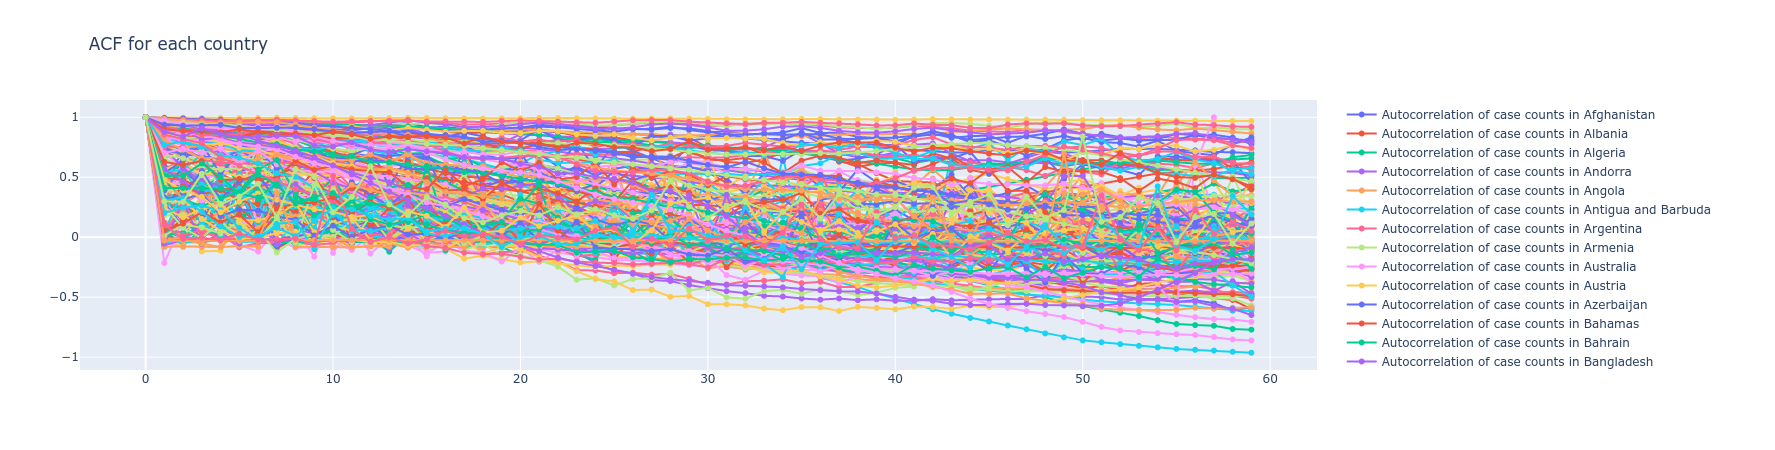

In [32]:
fig = go.Figure(data = [go.Scatter(y=autocorr_df[col],
                                   mode='lines+markers',
                                   name='Autocorrelation of case counts in ' + col
                                  ) for col in autocorr_df.columns]
               ).update_layout(title='ACF for each country',
                               showlegend=True
                              )
fig.show()

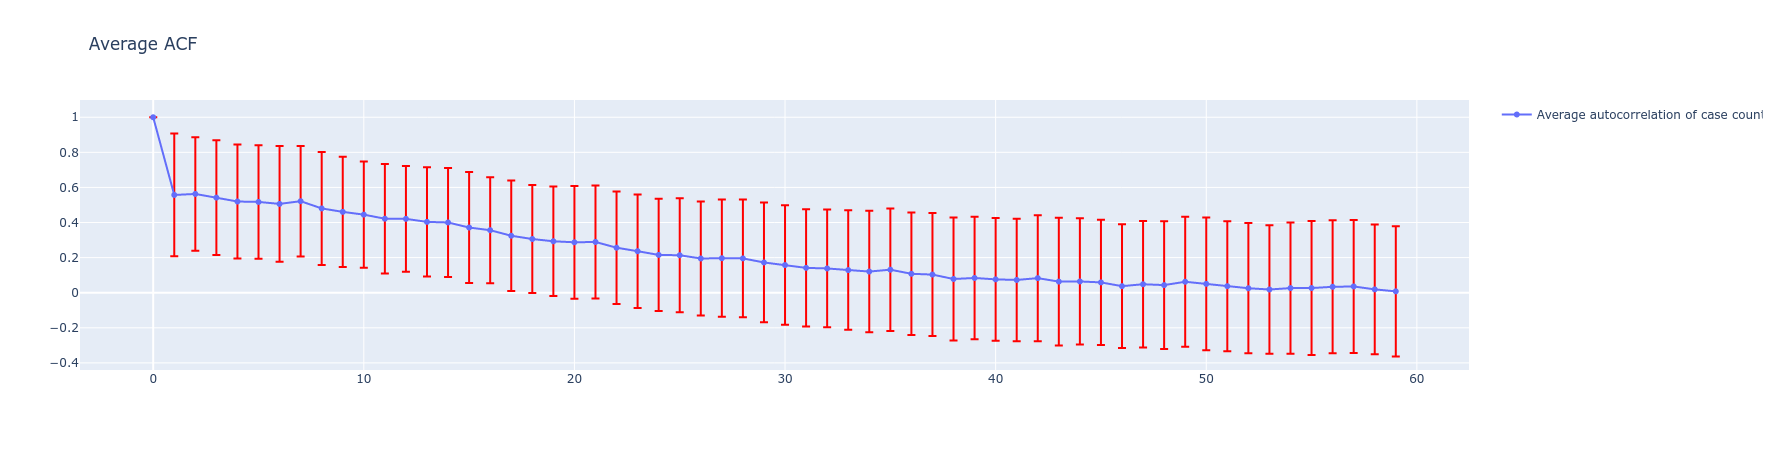

In [33]:
fig = go.Figure(data = go.Scatter(y=autocorr_df.mean(axis=1),
                                  mode='lines+markers',
                                  name='Average autocorrelation of case counts',
                                  error_y=dict(
                                      type='data',
                                      array=autocorr_df.std(axis=1),
                                      color='red',
                                      visible=True
                                  )
                                 )
               ).update_layout(title='Average ACF',
                              showlegend=True
                             )
fig.show()

The autocorrelations seem to be quite widely spread, and an ARIMA model or similar may not be effective at predicting the case counts. This also emphasises how the case counts for each country differ, and not including the idosyncrasies may result in reduced model performance. Perhaps a transformation of the underlying data should be considered, especially one that can make the process stationary.

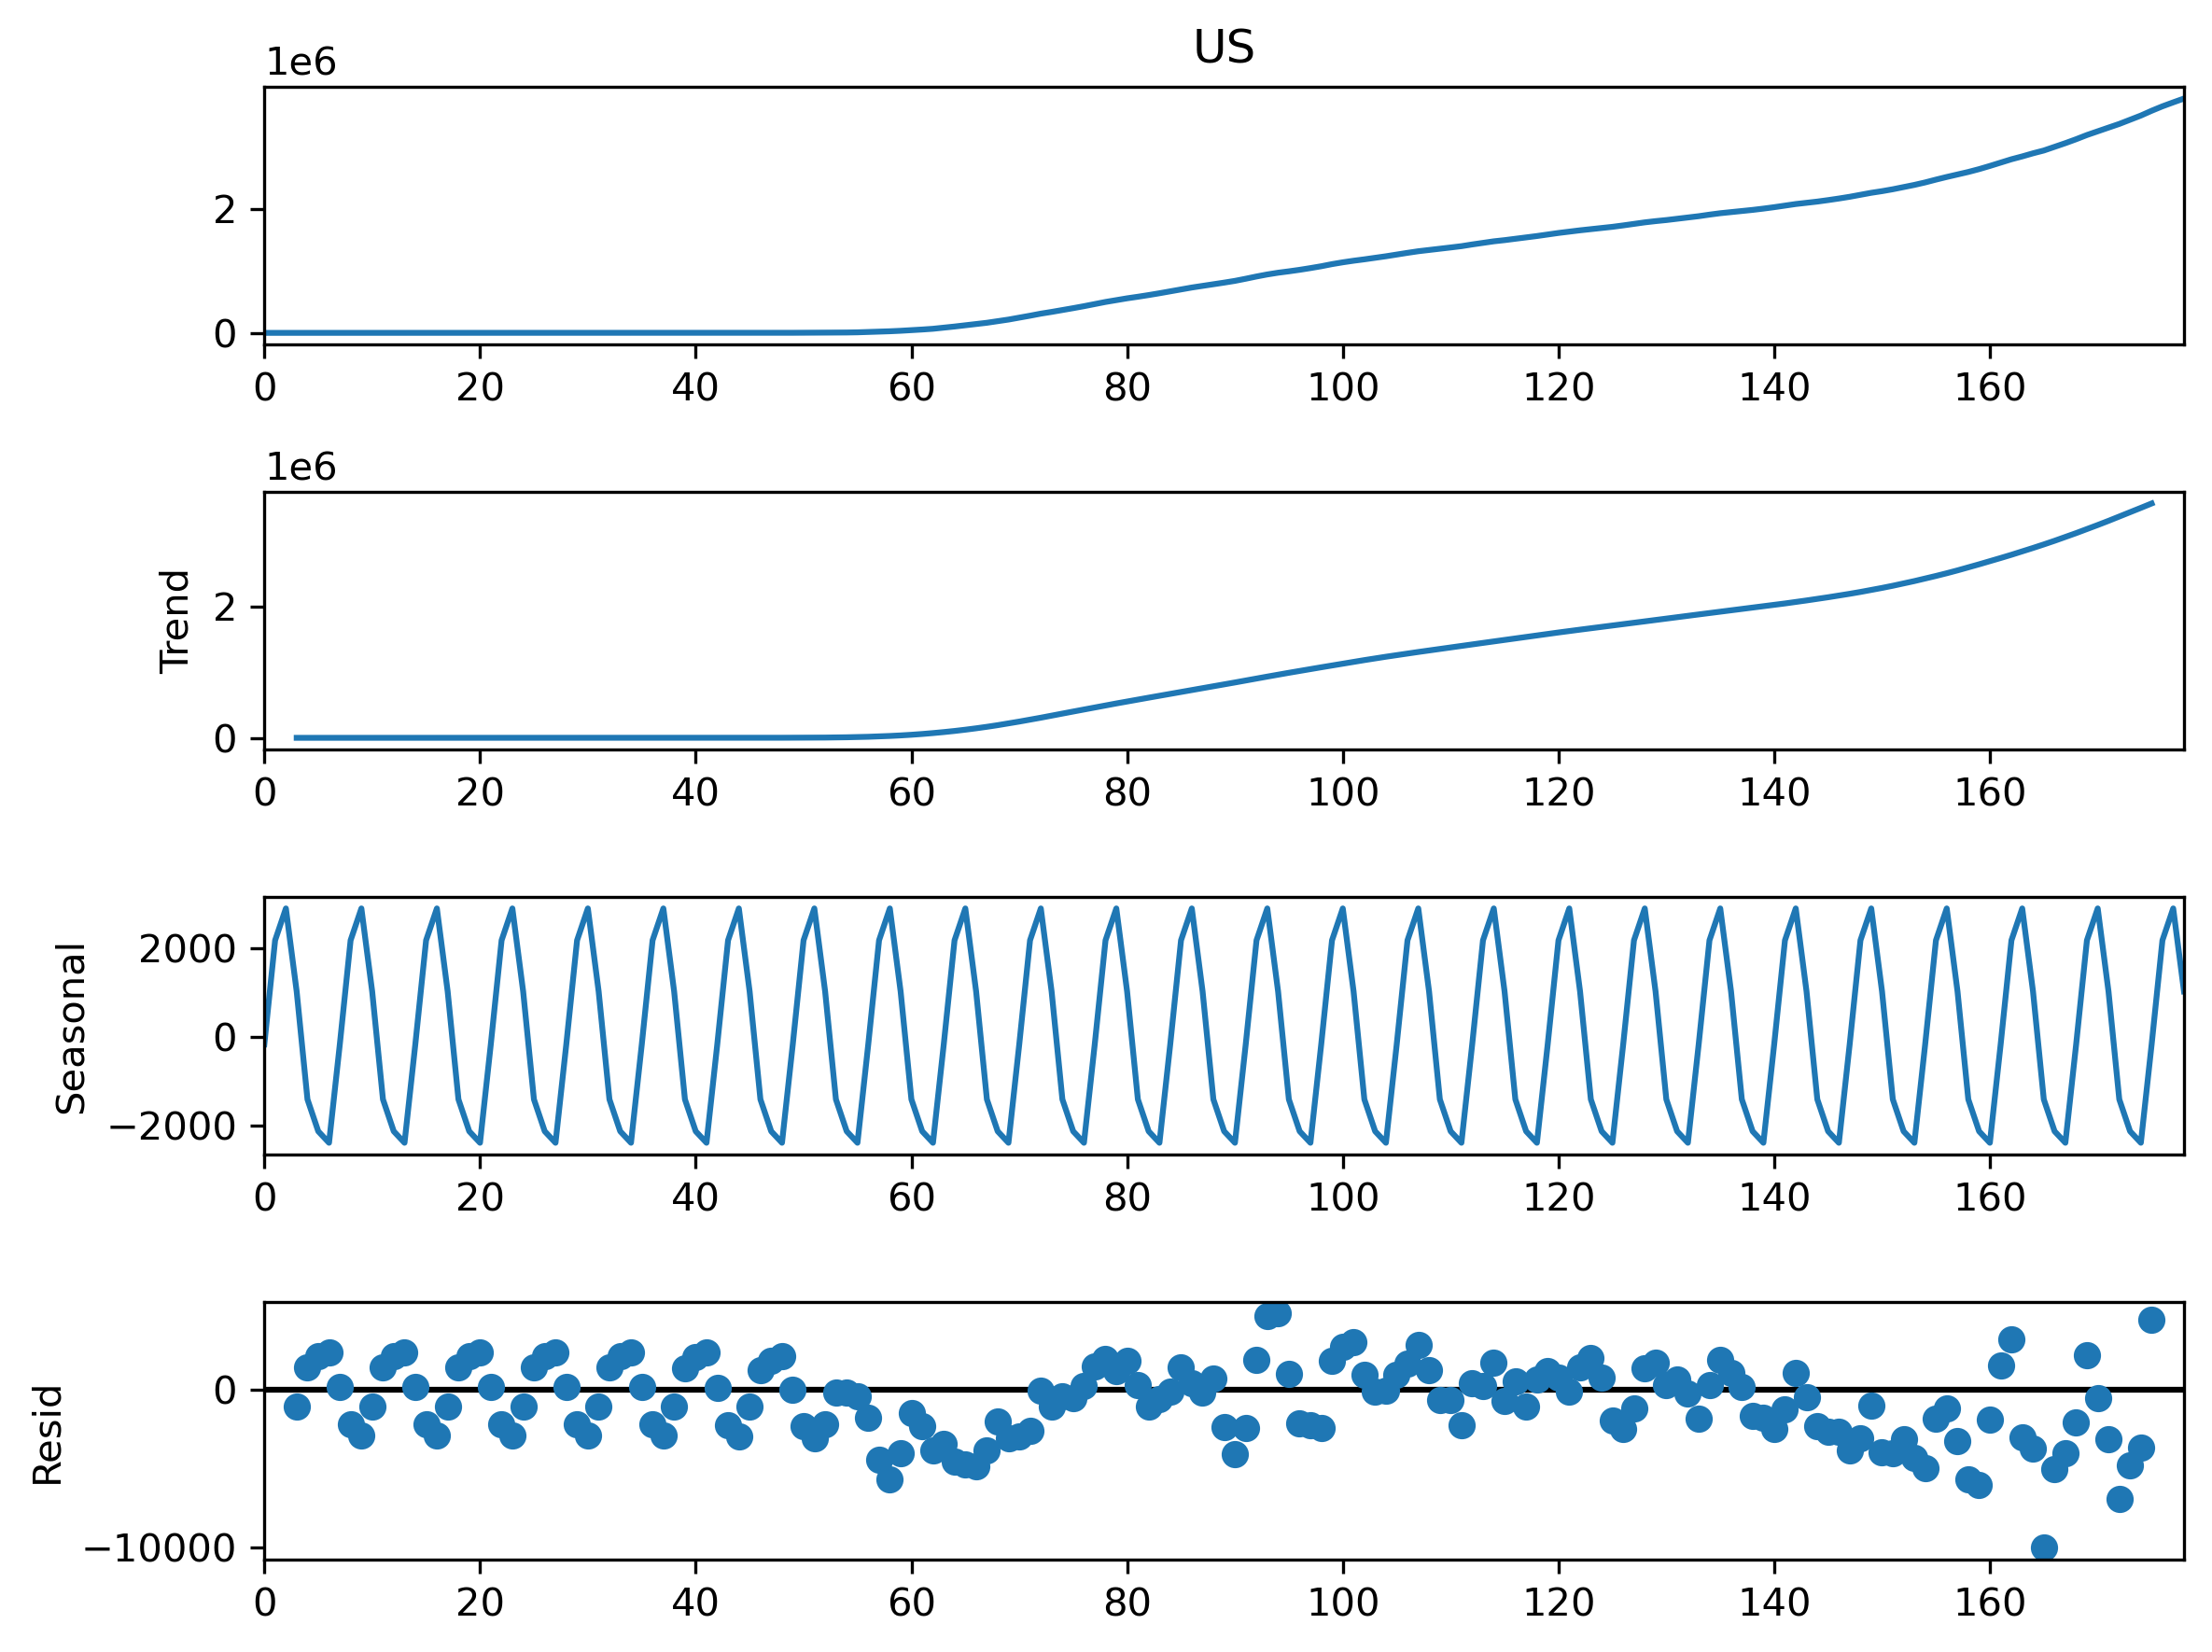

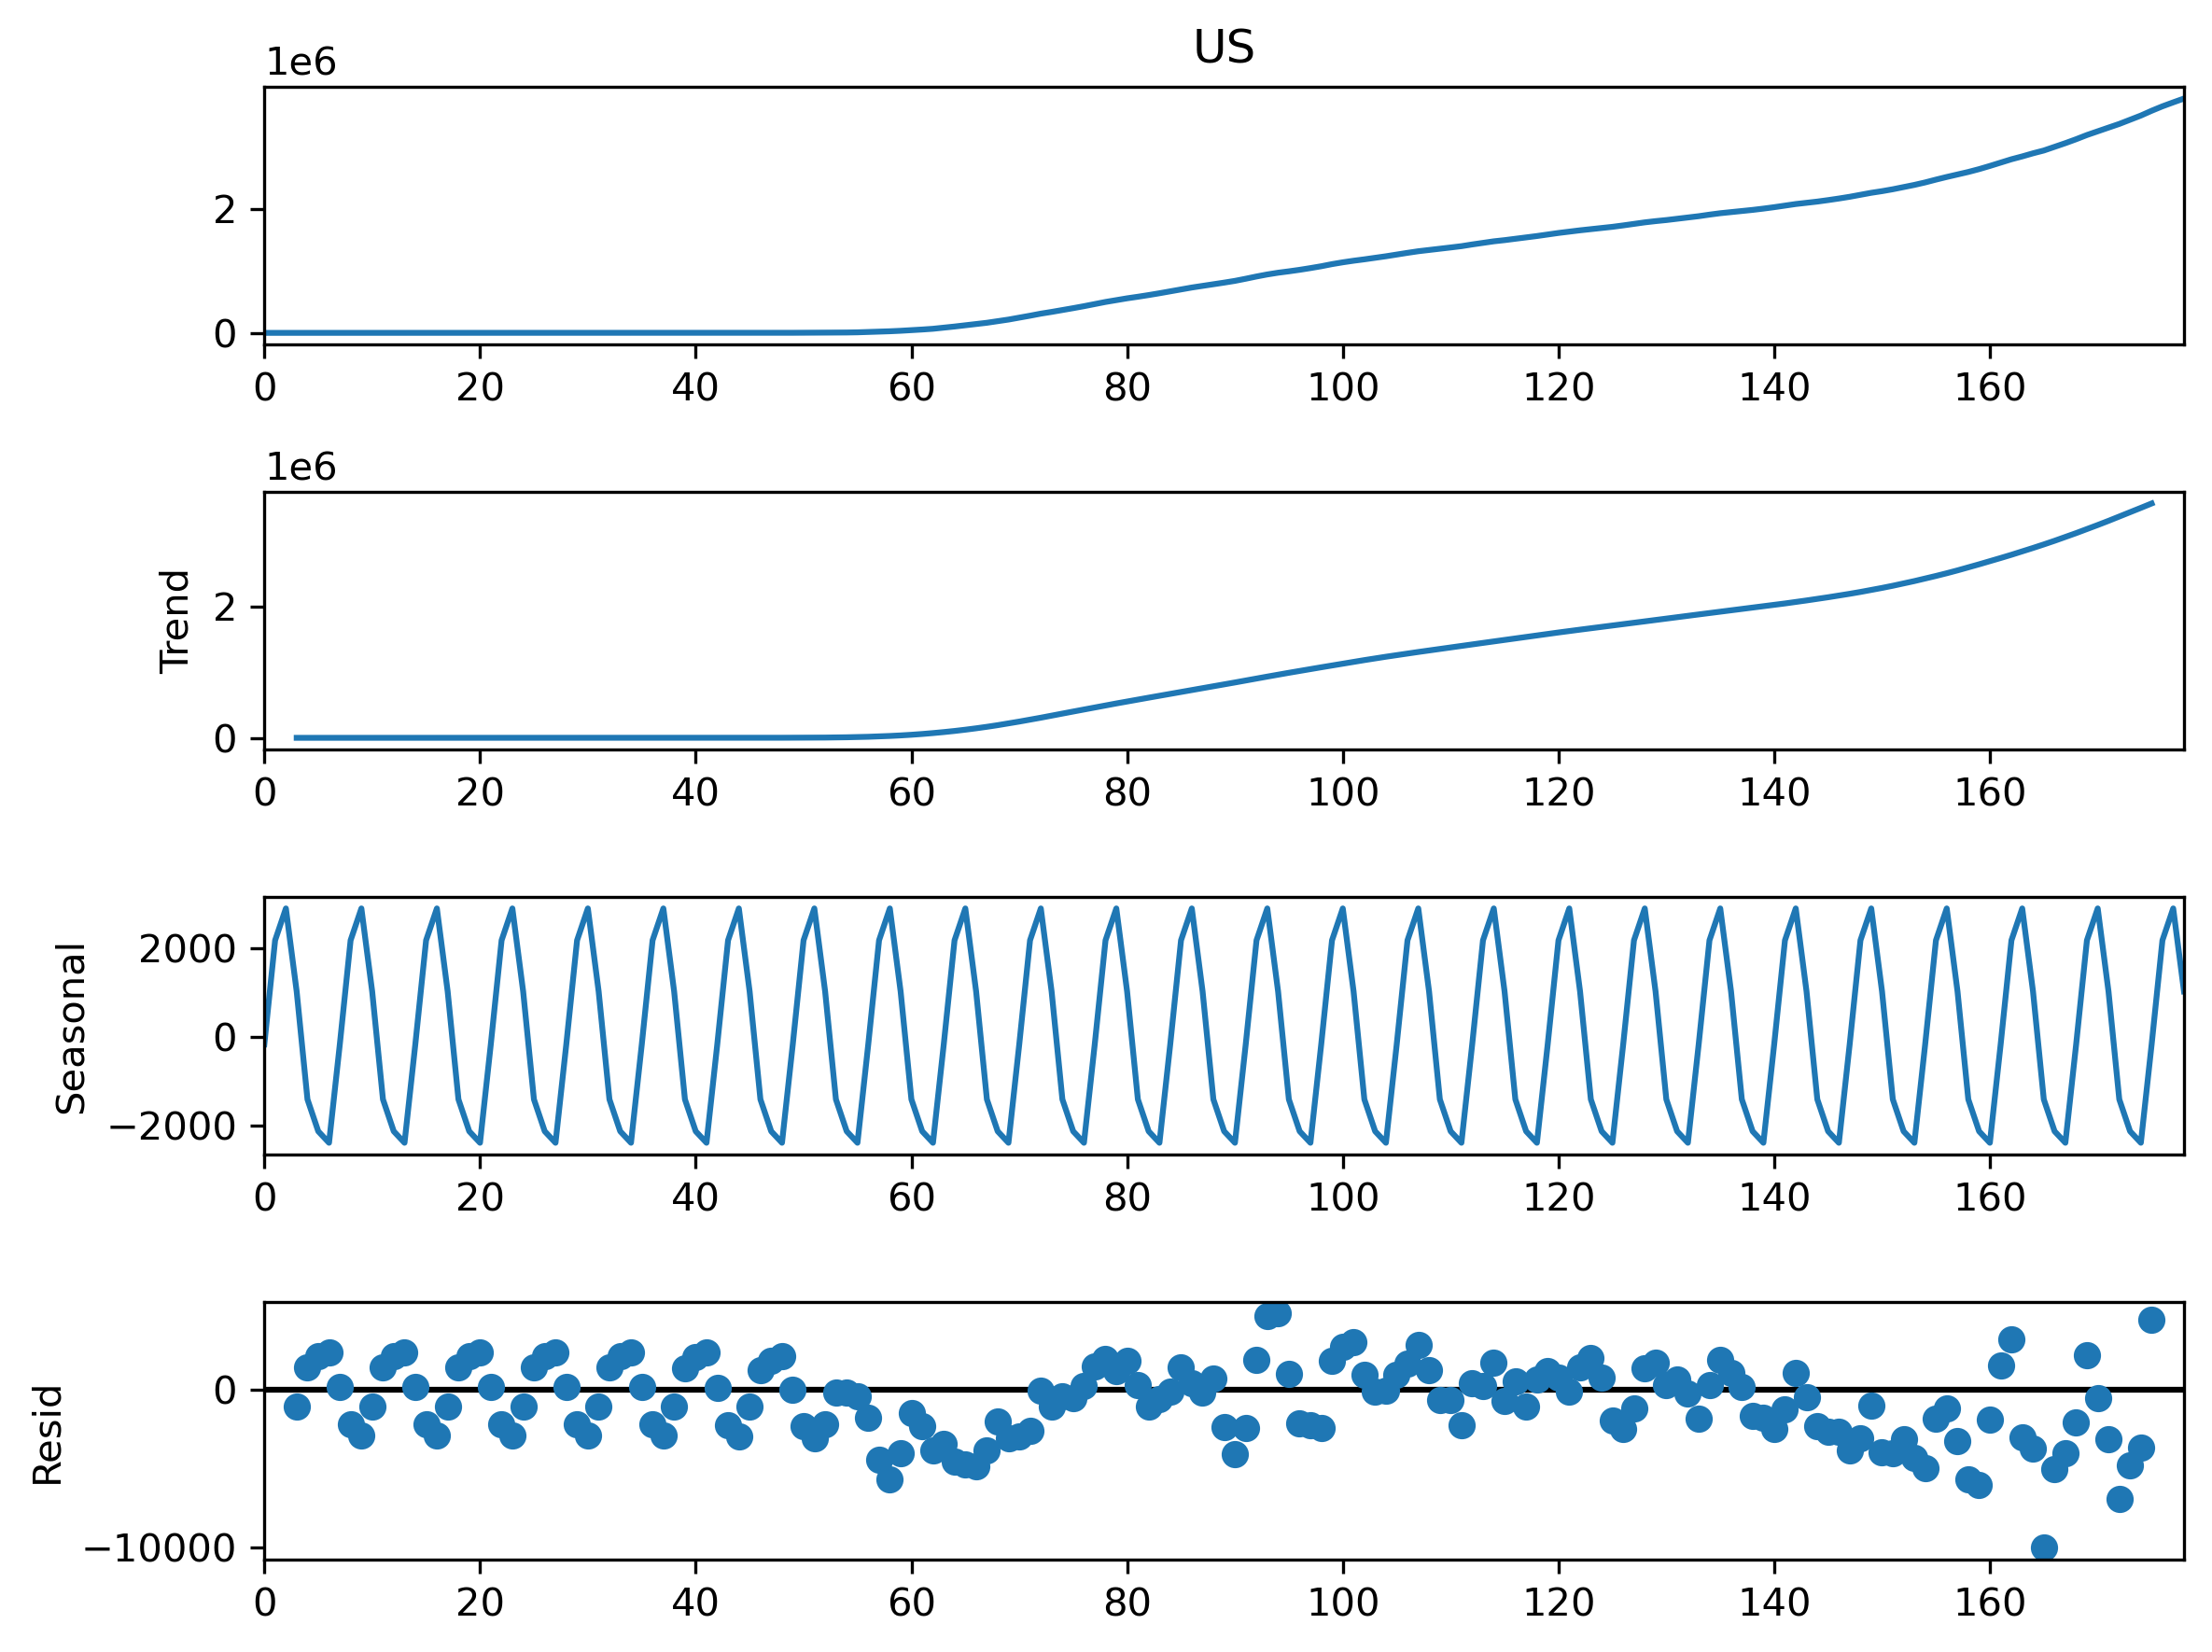

In [34]:
sm.tsa.seasonal_decompose(aligned_1['US'].dropna(), period=7).plot()

## Decision tree/Gradient Boosted Machine models


In [35]:
xg_train = xgb.DMatrix(data=train_val_df.iloc[:, :-1], label=train_val_df.iloc[:, -1])
xg_test = xgb.DMatrix(data=test_df.iloc[:, :-1], label=test_df.iloc[:, -1])

xg_params = [] # use default parameters for a basic model, see https://xgboost.readthedocs.io/en/latest/parameter.html

xgb_model = xgb.train(xg_params, xg_train)

Test set MSLE: 0.09138180218454497


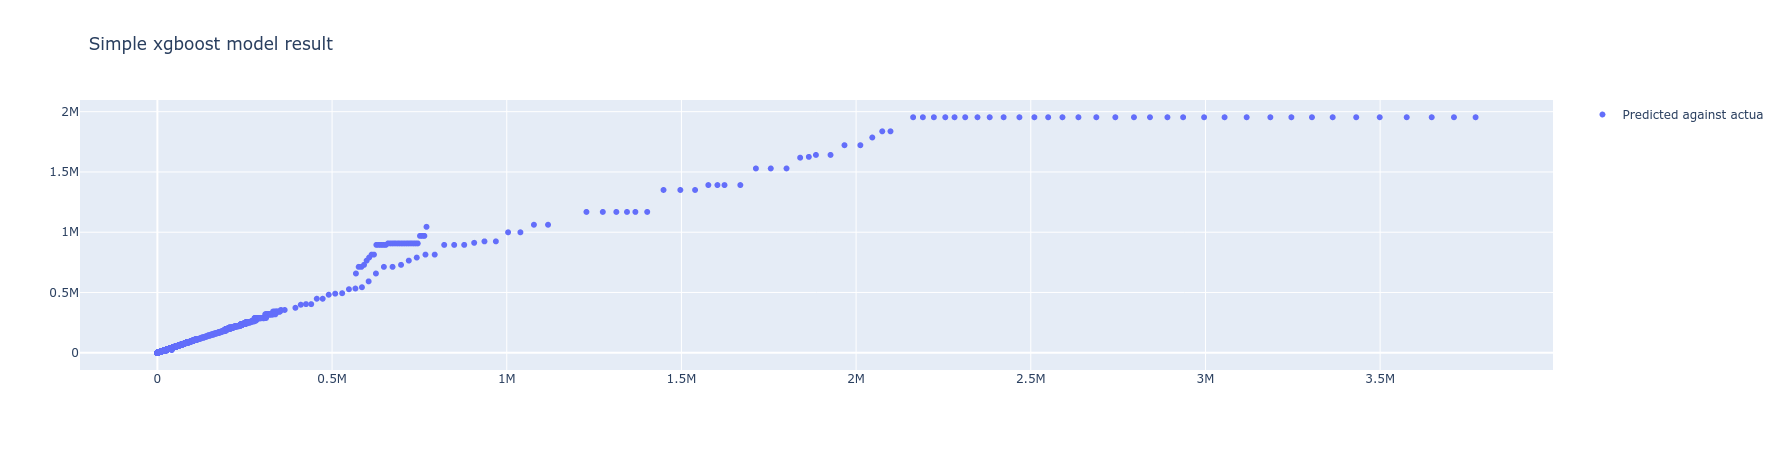

In [36]:
xg_test_pred = xgb_model.predict(xg_test)

print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], xg_test_pred)}")

fig = go.Figure(data = go.Scatter(x=test_df.iloc[:, -1],
                                  y=xg_test_pred,
                                  name='Predicted against actual',
                                  mode='markers'
                                 )
               ).update_layout(title='Simple xgboost model result',
                               showlegend=True
                              )
fig.show()

The MSLE from this simple model seems to be much higher than the linear regression model. However, this seems to be because of the outlier (countries) in USA and Brazil, which possess a disproportionately high case rate compared to other countries, resulting the focus of the leaves on lower values. This would present a problem with prediction moving forward, since the values increase with time, and also the case count in the USA is expected to increase even further.

As we are using the default parameters for simplicity, it is also a possibility that the selected parameters may not be a good fit for this model. Plotting the tree should give us a better idea of how it functions.

<AxesSubplot:>

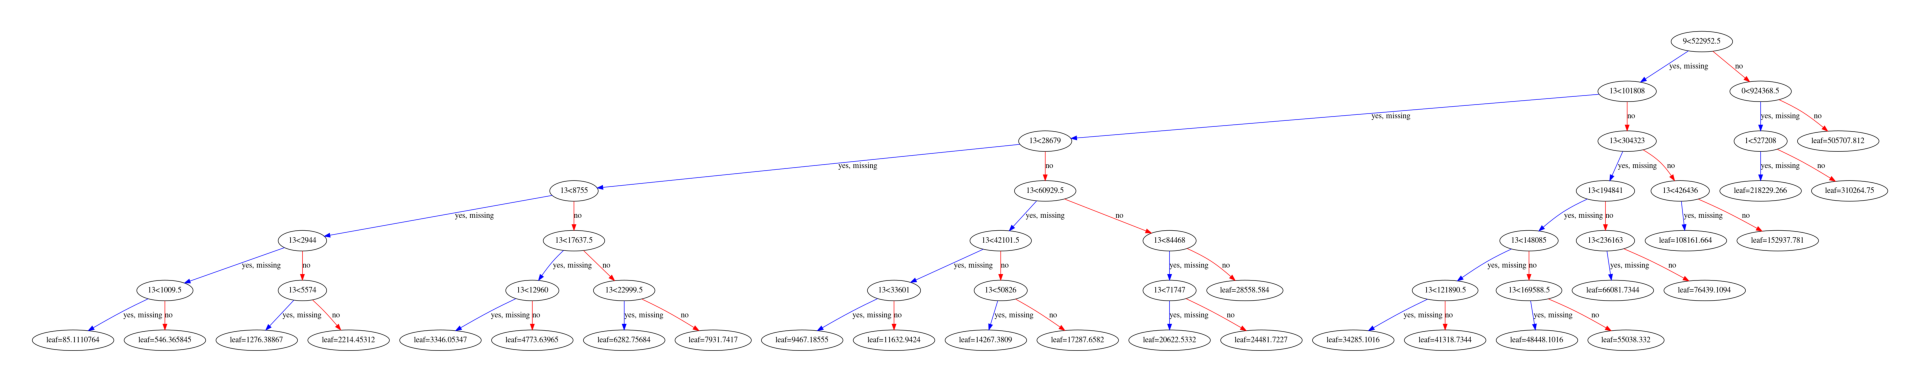

In [37]:
xgb.plot_tree(xgb_model)

According to this diagram, 13 is being used at all nodes but two, which use 0 and 9. 

In [38]:
xg_train.feature_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

## Neural network models
We next move on to neural network models. For the basic fully-connected neural network model, it is a simple, straightforward analogue of the linear regression done above. A few features (see the variables chosen for the linear regression) are used as inputs to the model. We will also look at models which accept sequences as inputs, which complicates matters. While it is perfectly fine to use the transformed dataset that we currently have, it also means that we may lose out on the benefits of the sequence models available to us, such as the ability to use the whole history of the data. It is also desirable for us to try to use the dynamics of the interaction between countries to predict the relationships between their case rates, something which cannot be done with the present dataset.

In [39]:
# Simple fully-connected 2 layer model

simple_fully_connected = tf.keras.models.Sequential([
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1)#, activation='relu')
])

simple_fully_connected.compile(optimizer='adam',
                               loss='msle',
                               metrics=['msle']
                              )

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

simple_fully_connected_history = simple_fully_connected.fit(x=train_df.iloc[:, :-1],
                                                            y=train_df.iloc[:, -1],
                                                            epochs=100,
                                                            callbacks=[lr_schedule],
                                                            verbose=1
                                                           )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

428/428 [==============================] - 0s 669us/step - loss: 7.7342 - msle: 7.7342 - lr: 1.0000e-08
Epoch 2/100
428/428 [==============================] - 0s 852us/step - loss: 7.7340 - msle: 7.7340 - lr: 1.1220e-08
Epoch 3/100
428/428 [==============================] - 0s 859us/step - loss: 7.7338 - msle: 7.7338 - lr: 1.2589e-08
Epoch 4/100
428/428 [==============================] - 0s 738us/step - loss: 7.7334 - msle: 7.7334 - lr: 1.4125e-08
Epoch 5/100
428/428 [=======================

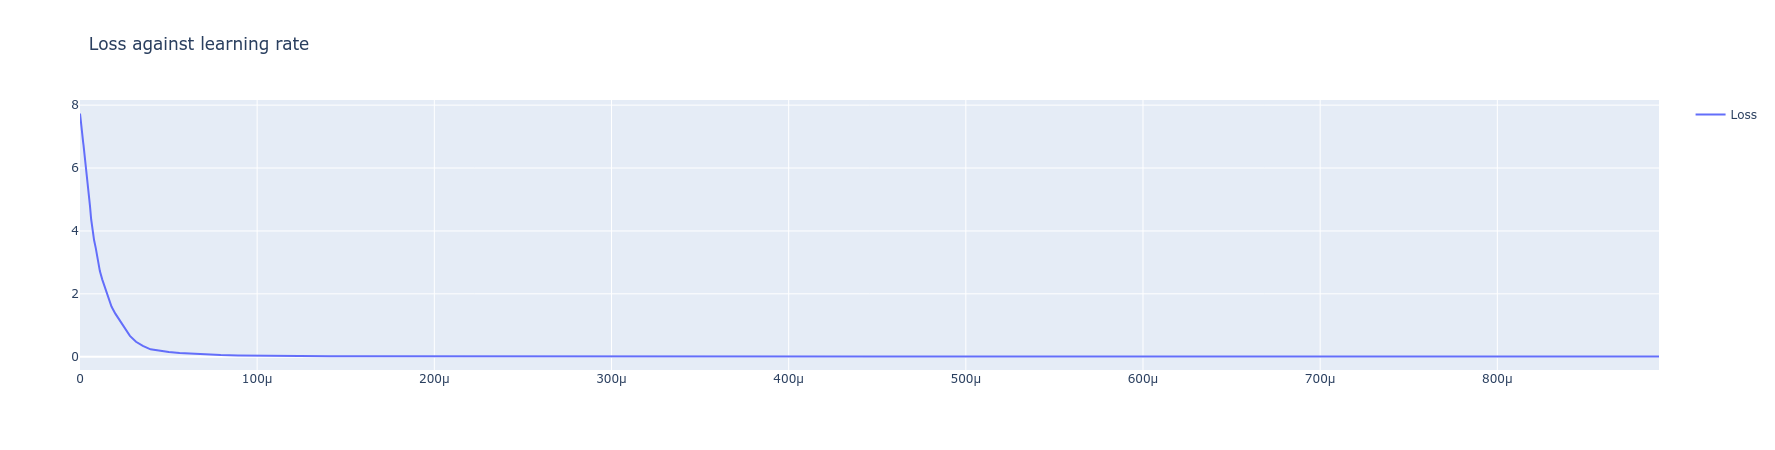

In [40]:
fig = go.Figure(data = go.Scatter(x=simple_fully_connected_history.history['lr'],
                                   y=simple_fully_connected_history.history['loss'],
                                   name='Loss'
                                  )
               ).update_layout(title='Loss against learning rate',
                               showlegend=True
                              )
fig.show()

In [41]:
val, idx = min((val, idx) for (idx, val) in enumerate(simple_fully_connected_history.history['loss']))
print(f"Minimum loss found at learning rate {simple_fully_connected_history.history['lr'][idx]} (epoch {idx}): {val}")

Minimum loss found at learning rate 0.0008912509656511247 (epoch 99): 0.0074540600180625916


In [42]:
# Simple fully-connected 2 layer model with ReLU final layer activation

simple_fully_connected_relu = tf.keras.models.Sequential([
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

simple_fully_connected_relu.compile(optimizer='adam',
                                    loss='msle',
                                    metrics=['msle']
                                   )

simple_fully_connected_relu_history = simple_fully_connected_relu.fit(x=train_df.iloc[:, :-1],
                                                                      y=train_df.iloc[:, -1],
                                                                      epochs=100,
                                                                      callbacks=[lr_schedule],
                                                                      verbose=1
                                                                     )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

428/428 [==============================] - 0s 669us/step - loss: 1.6229 - msle: 1.6229 - lr: 1.0000e-08
Epoch 2/100
428/428 [==============================] - 0s 658us/step - loss: 1.6220 - msle: 1.6220 - lr: 1.1220e-08
Epoch 3/100
428/428 [==============================] - 0s 743us/step - loss: 1.6209 - msle: 1.6209 - lr: 1.2589e-08
Epoch 4/100
428/428 [==============================] - 0s 714us/step - loss: 1.6197 - msle: 1.6197 - lr: 1.4125e-08
Epoch 5/100
428/428 [=======================

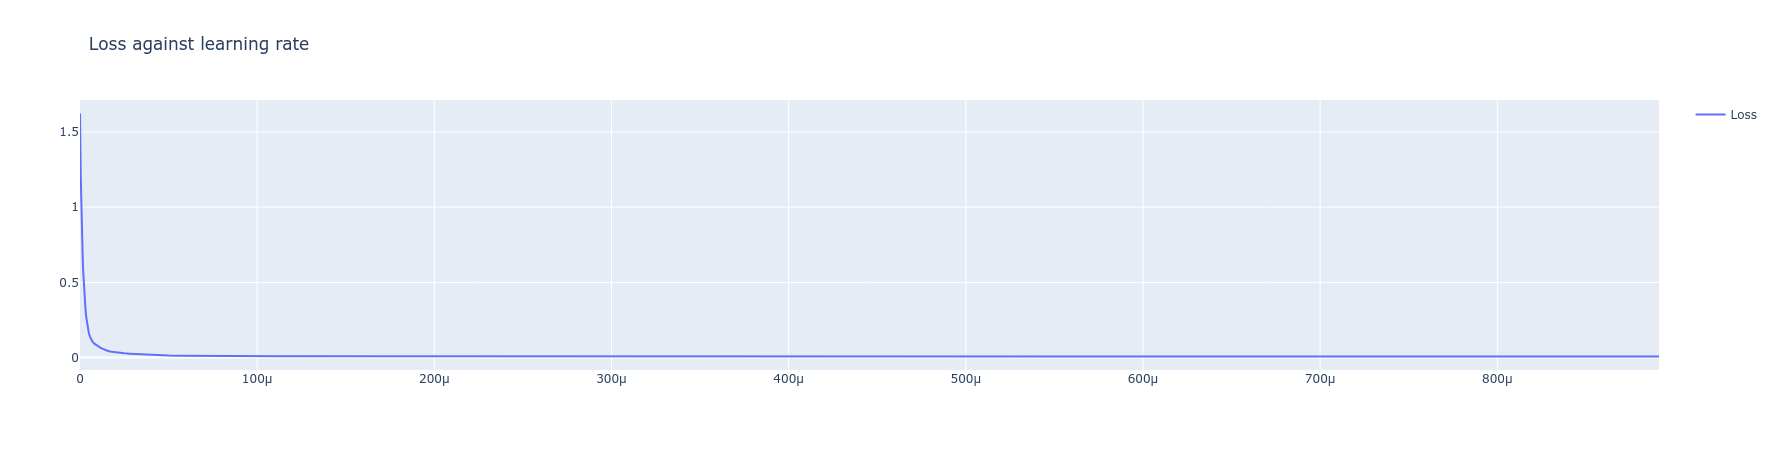

In [43]:
fig = go.Figure(data = go.Scatter(x=simple_fully_connected_relu_history.history['lr'],
                                   y=simple_fully_connected_relu_history.history['loss'],
                                   name='Loss'
                                  )
               ).update_layout(title='Loss against learning rate',
                               showlegend=True
                              )
fig.show()

In [44]:
val, idx = min((val, idx) for (idx, val) in enumerate(simple_fully_connected_relu_history.history['loss']))
print(f"Minimum loss found at learning rate {simple_fully_connected_relu_history.history['lr'][idx]} (epoch {idx}): {val}")

Minimum loss found at learning rate 0.0008912509656511247 (epoch 99): 0.00716220261529088


## Rearranging the split